In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import *

data_folder = 'data/msw_exp'

data_file_names = os.listdir(data_folder)

data_file_names = [f for f in data_file_names if f.endswith('.csv')]

data_file_list = [os.path.join(data_folder, f) for f in data_file_names]

data_file_names.sort(key=natural_keys)
data_file_list.sort(key=natural_keys)

In [2]:
import seaborn as sns

color_palette = sns.color_palette("colorblind", 4)
color_list = [tuple(color) for color in color_palette]

color_dict = {'wt': color_list[0],
              'braf': color_list[1],
              'kras': color_list[2],
              'braf-kras': color_list[3]}


In [3]:
dataframe_list = []
data_dict_list = []

green_key = 'Count_gfp_objects'
red_key = 'Count_texasred_objects'
blue_key = 'Count_dapi_objects'

index_column = 'FileName_dapi'

for file_path in data_file_list:
    df = pd.read_csv(file_path)
    dataframe_list.append(df)

    data = {}
    for i in df.index:
        cur_row  = df.iloc[i]
        name = cur_row[index_column]
        well_indx = name.find('_')
        well = cur_row[index_column][0:well_indx]
        if well in data.keys():
            data[well]['green'].append(cur_row[green_key])
            data[well]['red'].append(cur_row[red_key])
            data[well]['blue'].append(cur_row[blue_key])
        else:
            dict_t = {'green':[cur_row[green_key]],
                    'red':[cur_row[red_key]],
                    'blue':[cur_row[blue_key]]}
            data[well] = dict_t
    
    data_dict_list.append(data)


In [4]:
col_list = np.arange(8)+2
col_list = list(col_list)
col_list = [str(col) for col in col_list]

row_list = ['B','C','D','E','F','G']

gefitinib_conc = [0,7.5*10**-9,22*10**-9,67*10**-9,200*10**-9,600*10**-9,1800*10**-9,5400*10**-9]

# time = np.arange(len(data_dict_list[0]['B2']['green']))*4

col_key_color = {'2':'green',
           '3':'red',
           '4':'red',
           '5':'blue',
           '6':'green',
           '7':'red',
           '8':'red',
           '9':'blue'}

col_key_genotype = {'2':'wt',
                    '3':'braf',
                    '4':'kras',
                    '5':'braf-kras',
                    '6':'wt',
                    '7':'braf',
                    '8':'kras',
                    '9':'braf-kras'}

# for plate_indx in range(len(data_dict_list)):
#     # check if the plate is a 'c' plate

#     if data_file_names[plate_indx][1] == 'c':
#         fig,ax_list = plt.subplots(ncols=8,nrows=6,figsize=(10,8),
#                             sharex=True,sharey=True)

#         ax_list = ax_list.flatten()
#         ax_indx = 0

#         for row in row_list:
#             for col in col_list:
#                 ax = ax_list[ax_indx]
#                 key = row+col
#                 data = data_dict_list[plate_indx][key]

#                 color = col_key_color[col]
#                 genotype = col_key_genotype[col]
#                 plot_color = color_dict[genotype]

#                 ts = data[color]
#                 time = np.arange(len(ts))*4
#                 ax.plot(time,ts,color=plot_color,linewidth=2)

#                 ax_indx+=1
#                 ax.set_yscale('symlog',linthresh=10)
#                 ax.set_title(key)
                

#         fig.suptitle(data_file_list[plate_indx])
#         fig.tight_layout()

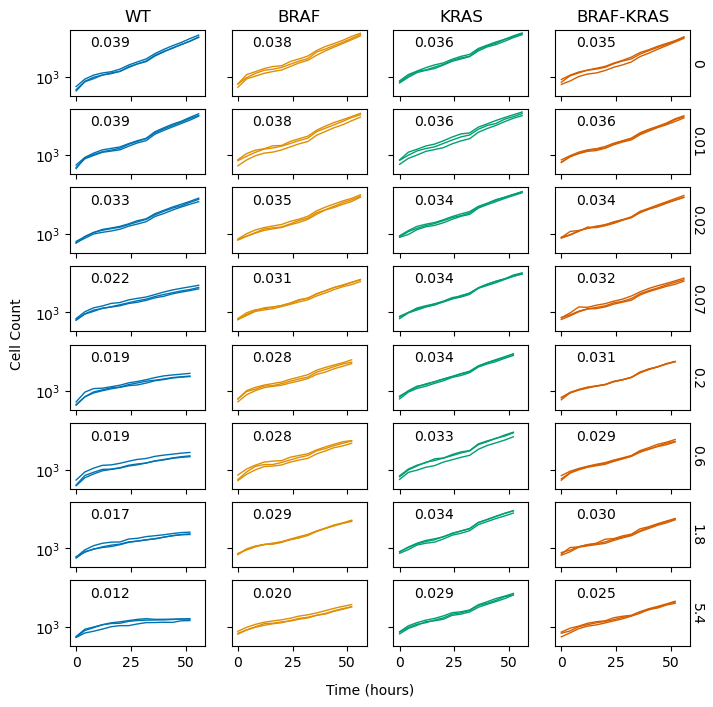

In [5]:
slope_est_options = {'exclude':2,'window':5,'step':2,'thresh':0.6}

fig,ax_list = plt.subplots(ncols=4,nrows=8,figsize=(8,8),sharey=True,sharex=True)
plate_count = 0
fig_row = 0

for plate_indx in range(len(data_dict_list)):
    # check if the plate is a 'c' plate
    
    if data_file_names[plate_indx][0:2] == '1c' or data_file_names[plate_indx][0:2] == '2c':
        
        # fig,ax_list = plt.subplots(ncols=8,nrows=2,figsize=(10,4),sharey=True,sharex=True)
        data = data_dict_list[plate_indx]
        key0 = list(data.keys())[0]
        time = np.arange(len(data[key0]['green']))*4
        
        for row_indx in [0,1]:
            col_indx = 0
            for col in col_list:
                # ax = ax_list[row_indx+2*plate_count,np.mod(col_indx,4)]
                ax = ax_list[fig_row,np.mod(col_indx,4)]

                rate_avg = []
                for rep in [1,2,3]:

                    row = row_list[row_indx*3+rep-1]

                    key = row+col
                    color = col_key_color[col]
                    genotype = col_key_genotype[col]
                    plot_color = color_dict[genotype]

                    ts = data[key][color]
                    time = np.arange(len(ts))*4
                    ax.plot(time,ts,color=plot_color,linewidth=1)

                    res = est_linear_slope(ts,time=time,**slope_est_options,debug=False)
                    rate_avg.append(res)
                
                rate_avg = np.nanmean(rate_avg)

                ax.annotate('{:.3f}'.format(rate_avg),(0.3,0.8),xycoords='axes fraction',ha='center',va='center',fontsize=10)

                col_indx+=1
                ax.set_yscale('symlog',linthresh=10)
                
                if col == '5' or col == '9':
                    fig_row+=1
        plate_count+=1

# add y axis label
fig.text(0.05, 0.5, 'Cell Count', va='center', rotation='vertical')

# add x axis label
fig.text(0.5, 0.05, 'Time (hours)', ha='center')

ax_list[0,0].set_title('WT')
ax_list[0,1].set_title('BRAF')
ax_list[0,2].set_title('KRAS')
ax_list[0,3].set_title('BRAF-KRAS')

for i,conc in enumerate(gefitinib_conc):
    ax_list[i,-1].set_ylabel(np.round(conc*10**6,2),rotation=-90,labelpad=10)
    ax_list[i,-1].yaxis.set_label_position("right")

fig.savefig('figures/cell_count_timetraces.eps',dpi=300,bbox_inches='tight')


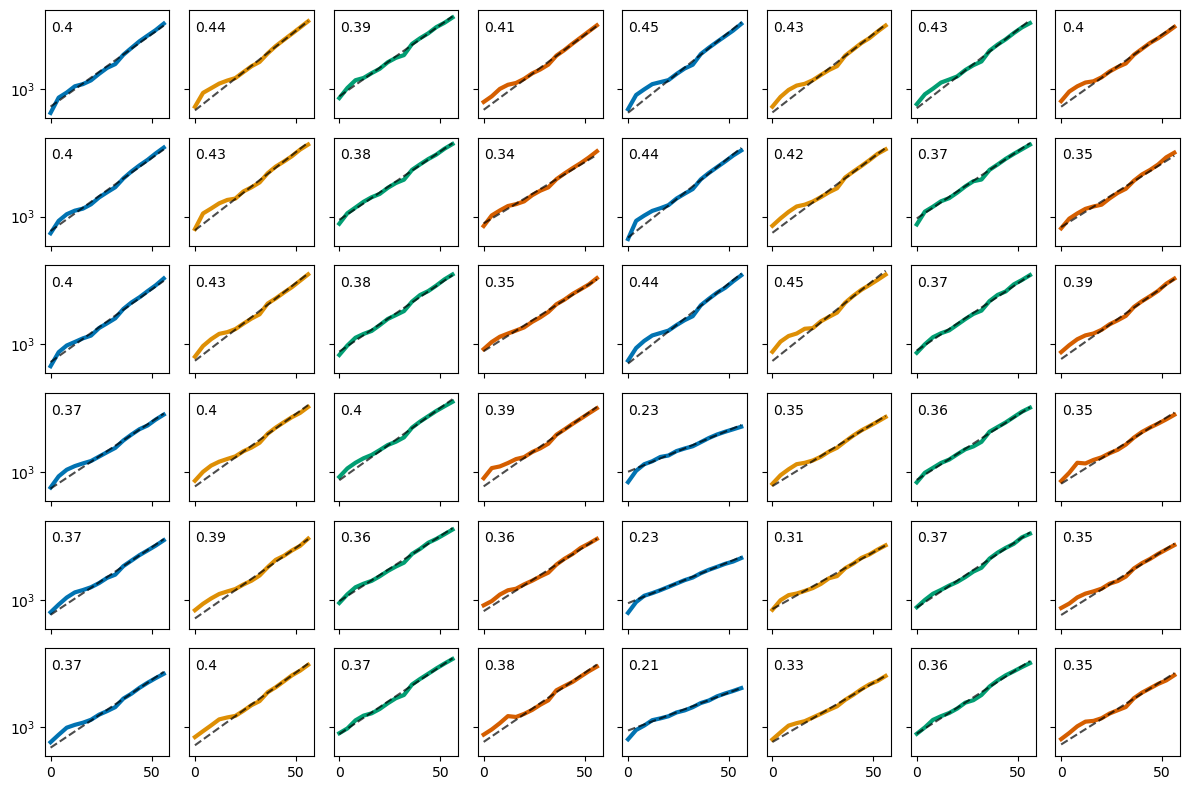

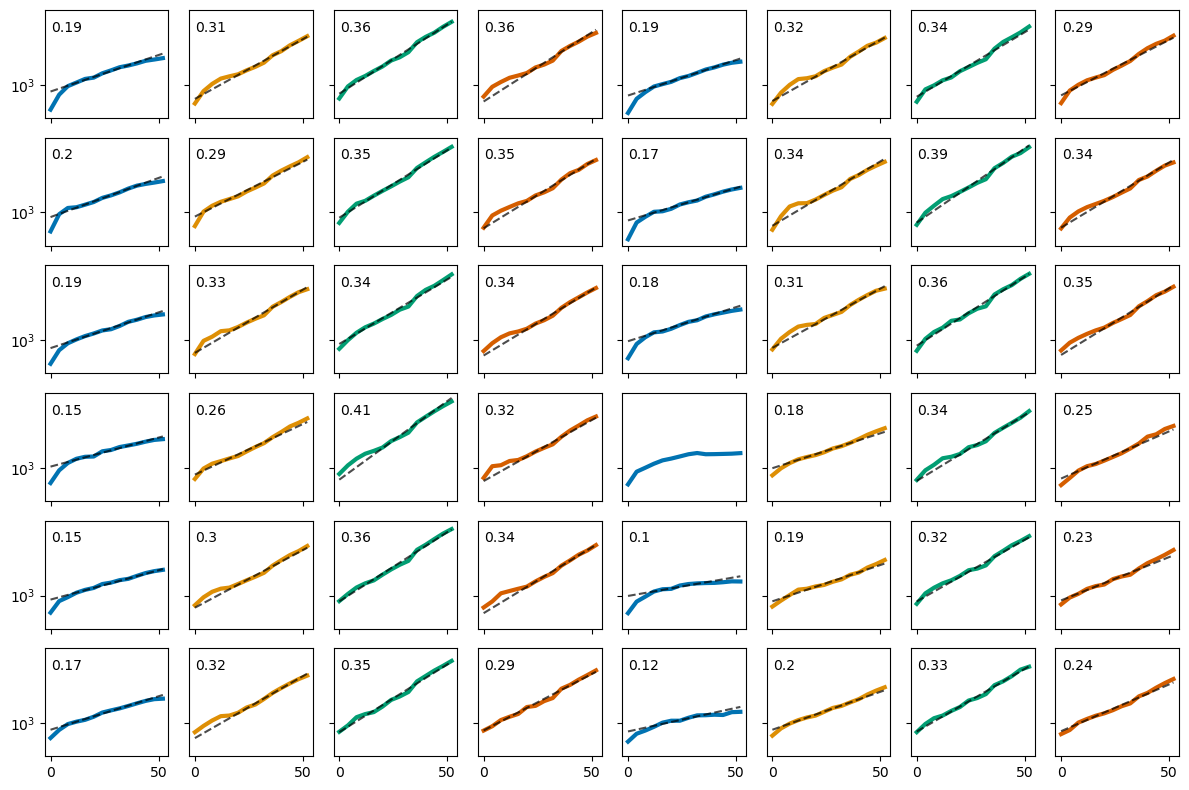

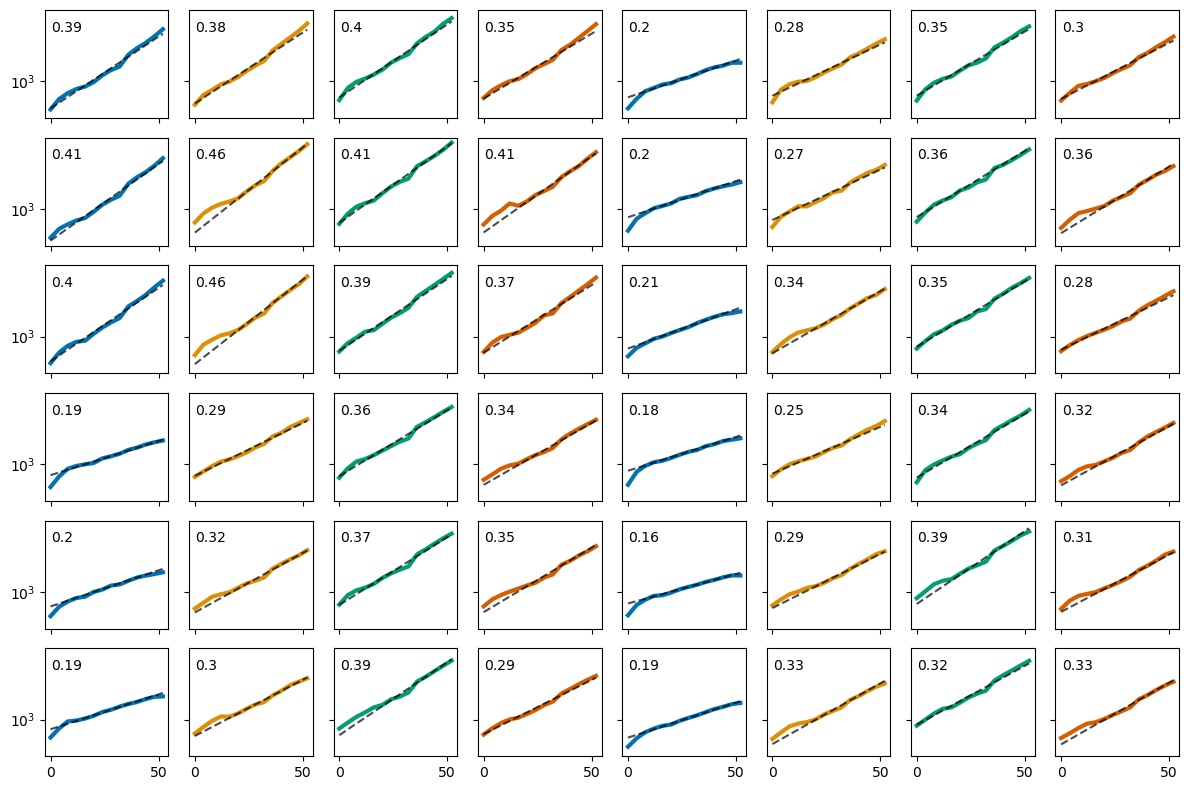

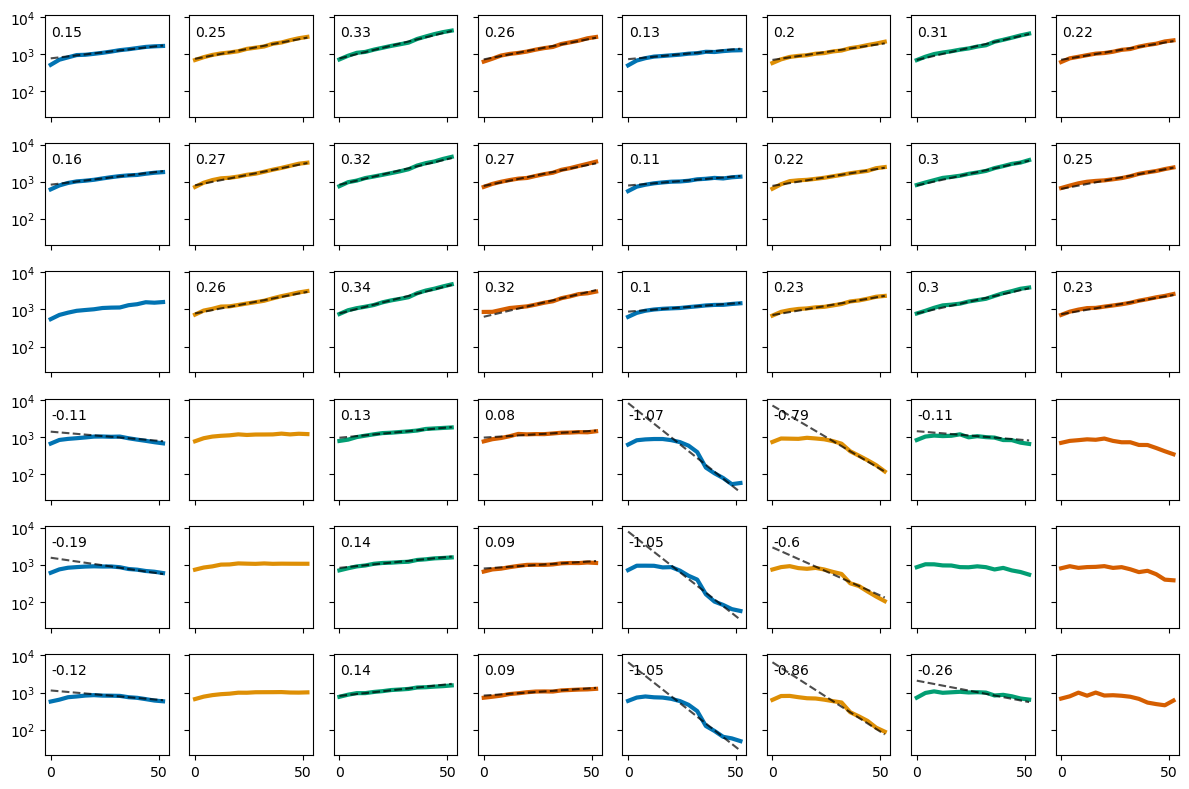

In [6]:
# slope_est_options = {'exclude':1,'window':5,'step':2,'thresh':0.5}
slope_est_options = {'exclude':3,'window':5,'step':2,'thresh':0.65}

for plate_indx in range(len(data_dict_list)):
    # check if the plate is a 'c' plate

    # if data_file_names[plate_indx][0:2] == '1c' or data_file_names[plate_indx][0:2] == '2c':
    if data_file_names[plate_indx][1] == 'c':
        fig,ax = plot_plate(data_dict_list[plate_indx],col_list=col_list,row_list=row_list,
                col_key_color=col_key_color,col_key_genotype=col_key_genotype,
                color_dict=color_dict,plot_fit=True,slope_est_options=slope_est_options,
                title=None,label_well=False);

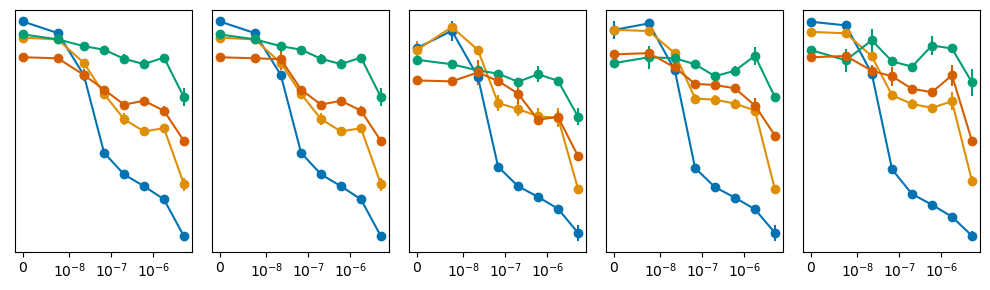

In [7]:
gefitinib_conc = [0,7.5*10**-9,22*10**-9,67*10**-9,200*10**-9,600*10**-9,1800*10**-9,5400*10**-9]

row_list = ['B','C','D','E','F','G']

gefitib_dict = {gefitinib_conc[0]:(1,(0,2),(0,3)), # key is concentration, value is (plate_indx,(row range indx,col range indx))
                gefitinib_conc[1]:(1,(0,2),(4,7)),
                gefitinib_conc[2]:(1,(3,5),(0,3)),
                gefitinib_conc[3]:(1,(3,5),(4,7)),
                gefitinib_conc[4]:(2,(0,2),(0,3)),
                gefitinib_conc[5]:(2,(0,2),(4,7)),
                gefitinib_conc[6]:(2,(3,5),(0,3)),
                gefitinib_conc[7]:(2,(3,5),(4,7))}
gr_dict = {}

auc_dict = {}

slope_est_options = {'exclude':3,'window':5,'step':2,'thresh':0.65}

# fig,ax_list = plt.subplots(ncols=8,nrows=6,figsize=(10,8))

# for step in [2,3,4]:
    # slope_est_options['step'] = step

fig,ax_list = plt.subplots(ncols=5,figsize=(10,3))

indx = 0

for thresh in [0.4,0.5,0.6,0.7,0.8]:
    slope_est_options['thresh'] = thresh

    for conc in gefitib_dict.keys():
        plate_indx = gefitib_dict[conc][0]
        row_range = gefitib_dict[conc][1]
        col_range = gefitib_dict[conc][2]
        
        # columns = [str(col) for col in np.arange(col_range[0],col_range[1]+1)]
        columns = [col for col in col_list[col_range[0]:col_range[1]+1]]
        rows = [row for row in row_list[row_range[0]:row_range[1]+1]]

        dict_t = {}
        auc_dict_t = {}

        for gen_indx in range(len(columns)):
            col = columns[gen_indx]
            gr_t = []
            auc_t = []
            for row in rows:
                key = row+col
                color = col_key_color[col]

                plate_name = str(plate_indx)+'c_counts.csv'

                plate_num = np.argwhere(np.array(data_file_names) == plate_name)[0][0]

                ts = data_dict_list[plate_num][key][color]
                time = np.arange(len(ts))*4

                col_indx = np.argwhere(np.array(col_list) == col)[0][0]
                row_indx = np.argwhere(np.array(row_list) == row)[0][0]
                
                slope_est = est_linear_slope(ts,time=time,**slope_est_options,
                                            return_fit=False,debug=False)
                gr_t.append(slope_est)

                auc_est = np.trapz(ts,time)/ts[0]
                auc_t.append(auc_est)

                # print(slope_est)
                # print('\n')

            mean_gr = np.nanmean(gr_t)
            std_err = np.nanstd(gr_t)/np.sqrt(len(gr_t))
            dict_t[col_key_genotype[col]] = (mean_gr,std_err)

            mean_auc = np.nanmean(auc_t)
            std_err_auc = np.nanstd(auc_t)/np.sqrt(len(auc_t))
            auc_dict_t[col_key_genotype[col]] = (mean_auc,std_err_auc)

        gr_dict[conc] = dict_t
        auc_dict[conc] = auc_dict_t

    # fig,ax = plt.subplots()
    genotypes = ['wt','braf','kras','braf-kras']

    ax = ax_list[indx]

    for gen_indx in range(4):
        genotype = genotypes[gen_indx]
        # auc_list = []
        gr_list = []
        err_list = []
        for conc in gefitinib_conc:
            gr_list.append(gr_dict[conc][genotype][0])
            err_list.append(gr_dict[conc][genotype][1])
            # auc_list.append(auc_dict[conc][genotype][0])
            # err_list.append(auc_dict[conc][genotype][1])

        ax.errorbar(gefitinib_conc,gr_list,yerr=err_list,color=color_dict[genotype],marker='o',label=genotype)

    # ax.legend(frameon=False)
    ax.set_yticks([])
    ax.set_xscale('symlog',linthresh=10**-8)
    indx+=1

fig.tight_layout()

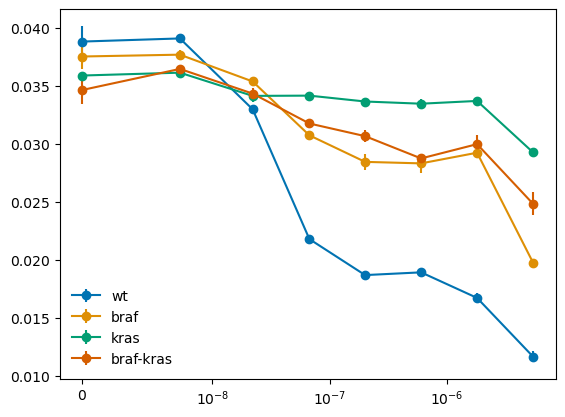

In [8]:
fig,ax = plt.subplots()
genotypes = ['wt','braf','kras','braf-kras']

slope_est_options = {'exclude':2,'window':5,'step':2,'thresh':0.6}

gr_dict = {}

auc_dict = {}

for conc in gefitib_dict.keys():
    plate_indx = gefitib_dict[conc][0]
    row_range = gefitib_dict[conc][1]
    col_range = gefitib_dict[conc][2]
    
    # columns = [str(col) for col in np.arange(col_range[0],col_range[1]+1)]
    columns = [col for col in col_list[col_range[0]:col_range[1]+1]]
    rows = [row for row in row_list[row_range[0]:row_range[1]+1]]

    dict_t = {}
    auc_dict_t = {}

    for gen_indx in range(len(columns)):
        col = columns[gen_indx]
        gr_t = []
        auc_t = []
        for row in rows:
            key = row+col
            color = col_key_color[col]

            plate_name = str(plate_indx)+'c_counts.csv'

            plate_num = np.argwhere(np.array(data_file_names) == plate_name)[0][0]

            ts = data_dict_list[plate_num][key][color]
            time = np.arange(len(ts))*4

            col_indx = np.argwhere(np.array(col_list) == col)[0][0]
            row_indx = np.argwhere(np.array(row_list) == row)[0][0]
            
            slope_est = est_linear_slope(ts,time=time,**slope_est_options,
                                        return_fit=False,debug=False)
            gr_t.append(slope_est)

            auc_est = np.trapz(ts,time)/ts[0]
            auc_t.append(auc_est)

            # print(slope_est)
            # print('\n')

        mean_gr = np.nanmean(gr_t)
        std_err = np.nanstd(gr_t)/np.sqrt(len(gr_t))
        dict_t[col_key_genotype[col]] = (mean_gr,std_err)

        mean_auc = np.nanmean(auc_t)
        std_err_auc = np.nanstd(auc_t)/np.sqrt(len(auc_t))
        auc_dict_t[col_key_genotype[col]] = (mean_auc,std_err_auc)

    gr_dict[conc] = dict_t
    auc_dict[conc] = auc_dict_t

for gen_indx in range(4):
    genotype = genotypes[gen_indx]
    # auc_list = []
    gr_list = []
    err_list = []
    for conc in gefitinib_conc:
        gr_list.append(gr_dict[conc][genotype][0])
        err_list.append(gr_dict[conc][genotype][1])
        # auc_list.append(auc_dict[conc][genotype][0])
        # err_list.append(auc_dict[conc][genotype][1])

    ax.errorbar(gefitinib_conc,gr_list,yerr=err_list,color=color_dict[genotype],marker='o',label=genotype)

ax.legend(frameon=False)
ax.set_xscale('symlog',linthresh=10**-8)


/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_48816/1249439780.py:2: RuntimeWarning: divide by zero encountered in log10
  xfit = np.logspace(np.min(np.log10(gefitinib_conc[1:])),np.max(np.log10(gefitinib_conc)),100)
/Users/kinge2/repos/msw_analysis/utils.py:200: RuntimeWarning: invalid value encountered in scalar power
  y = gmax + ((gmin - gmax) * conc**hc) / (ic_50**hc + conc**hc)


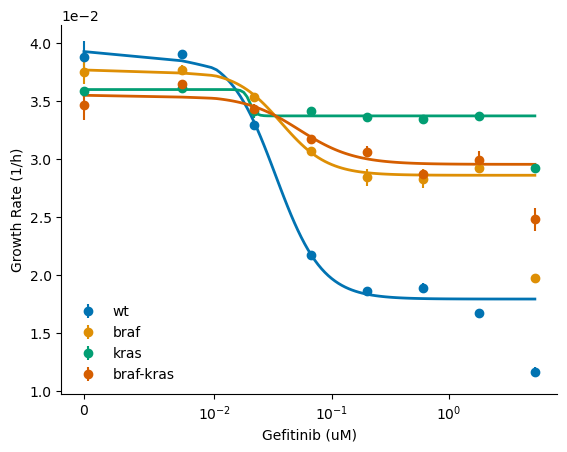

In [9]:
fig,ax = plt.subplots()
xfit = np.logspace(np.min(np.log10(gefitinib_conc[1:])),np.max(np.log10(gefitinib_conc)),100)

# append 0 to the left of the xfit array

xfit = np.append(0,xfit)

dr_params = []

genotype_gr_dict = {}

for gen_indx in range(4):
    genotype = genotypes[gen_indx]
    # auc_list = []
    gr_list = []
    err_list = []
    dict_t = {}
    for conc in gefitinib_conc:
        gr_list.append(gr_dict[conc][genotype][0])
        err_list.append(gr_dict[conc][genotype][1])
    
    popt,pcov = est_dr_params(gefitinib_conc[0:-1],gr_list[0:-1])

    ax.errorbar(np.array(gefitinib_conc)*10**6,gr_list,yerr=err_list,color=color_dict[genotype],
                marker='o',label=genotype,linestyle='')
    
    yfit = hill_fn(xfit,*popt)

    ax.plot(xfit*10**6 ,yfit,color=color_dict[genotype],linewidth=2)

    dr_params.append(popt)
    dict_t['err'] = err_list
    dict_t['gr'] = gr_list

    genotype_gr_dict[genotype] = dict_t

ax.set_xscale('symlog',linthresh=10**-2)
ax.legend(frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax.set_xlabel('Gefitinib (uM)')
ax.set_ylabel('Growth Rate (1/h)')

fig.savefig('figures/dr_fit_supp.pdf',dpi=300)

# change to micromolar x axis

In [21]:
# print gmax for each genotype

for gen_indx in range(4):
    genotype = genotypes[gen_indx]
    popt = dr_params[gen_indx]
    print(genotype)
    print(popt[2])

wt
2.1837479284869774
braf
2.1938399373783843
kras
17.454987955491827
braf-kras
1.84574304523484


In [11]:
dict_t = {'wt':genotype_gr_dict['wt']['gr'],
          'braf':genotype_gr_dict['braf']['gr'],
          'kras':genotype_gr_dict['kras']['gr'],
          'braf-kras':genotype_gr_dict['braf-kras']['gr'],
          'wt_err':genotype_gr_dict['wt']['err'],
          'braf_err':genotype_gr_dict['braf']['err'],
          'kras_err':genotype_gr_dict['kras']['err'],
          'braf-kras_err':genotype_gr_dict['braf-kras']['err'],
          'drug_conc':gefitinib_conc}

df = pd.DataFrame(dict_t)

df.to_csv('data/gr_est.csv',index=False)

In [12]:
# gefitinib_conc = [0,7.5*10**-9,22*10**-9,67*10**-9,200*10**-9,600*10**-9,1800*10**-9,5400*10**-9]
max_conc = 10*10**-6

osi_conc = []
for i in range(7):
    osi_conc.append(max_conc/(3**i))

# reverse the list and append 0
osi_conc.append(0)
osi_conc = osi_conc[::-1]

print(osi_conc)

row_list = ['B','C','D','E','F','G']

osi_dict = {osi_conc[0]:(3,(0,2),(0,3)), # key is concentration, value is (plate_indx,(row range indx,col range indx))
                osi_conc[1]:(3,(0,2),(4,7)),
                osi_conc[2]:(3,(3,5),(0,3)),
                osi_conc[3]:(3,(3,5),(4,7)),
                osi_conc[4]:(4,(0,2),(0,3)),
                osi_conc[5]:(4,(0,2),(4,7)),
                osi_conc[6]:(4,(3,5),(0,3)),
                osi_conc[7]:(4,(3,5),(4,7))}
gr_dict = {}

slope_est_options = {'exclude':1,'window':5,'step':2,'thresh':0.6}

# fig,ax_list = plt.subplots(ncols=8,nrows=6,figsize=(10,8))

for conc in osi_dict.keys():
    plate_indx = osi_dict[conc][0]
    row_range = osi_dict[conc][1]
    col_range = osi_dict[conc][2]
    
    # columns = [str(col) for col in np.arange(col_range[0],col_range[1]+1)]
    columns = [col for col in col_list[col_range[0]:col_range[1]+1]]
    rows = [row for row in row_list[row_range[0]:row_range[1]+1]]

    dict_t = {}

    for gen_indx in range(len(columns)):
        col = columns[gen_indx]
        gr_t = []
        for row in rows:
            key = row+col
            color = col_key_color[col]

            plate_name = str(plate_indx)+'c_counts.csv'

            plate_num = np.argwhere(np.array(data_file_names) == plate_name)[0][0]

            ts = data_dict_list[plate_num][key][color]
            time = np.arange(len(ts))*4

            col_indx = np.argwhere(np.array(col_list) == col)[0][0]
            row_indx = np.argwhere(np.array(row_list) == row)[0][0]
            
            slope_est = est_linear_slope(ts,time=time,**slope_est_options,
                                         return_fit=False,debug=False)
            gr_t.append(slope_est)

        mean_gr = np.nanmean(gr_t)
        std_err = np.nanstd(gr_t)/np.sqrt(len(gr_t))
        dict_t[col_key_genotype[col]] = (mean_gr,std_err)
    gr_dict[conc] = dict_t

[0, 1.371742112482853e-08, 4.115226337448559e-08, 1.2345679012345677e-07, 3.7037037037037036e-07, 1.111111111111111e-06, 3.333333333333333e-06, 9.999999999999999e-06]


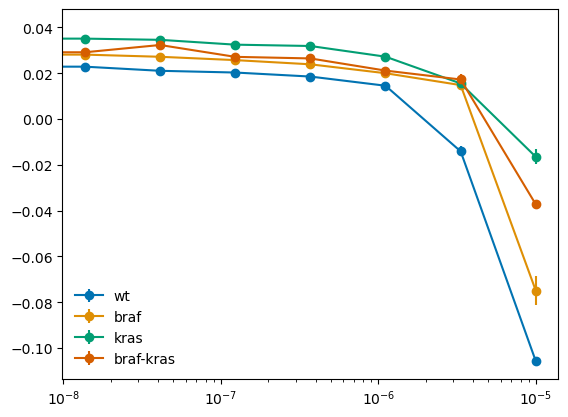

In [13]:
fig,ax = plt.subplots()
genotypes = ['wt','braf','kras','braf-kras']

for gen_indx in range(4):
    genotype = genotypes[gen_indx]
    gr_list = []
    err_list = []
    for conc in osi_conc:
        gr_list.append(gr_dict[conc][genotype][0])
        err_list.append(gr_dict[conc][genotype][1])
    ax.errorbar(osi_conc,gr_list,yerr=err_list,color=color_dict[genotype],marker='o',label=genotype)

ax.legend(frameon=False)
ax.set_xscale('log')

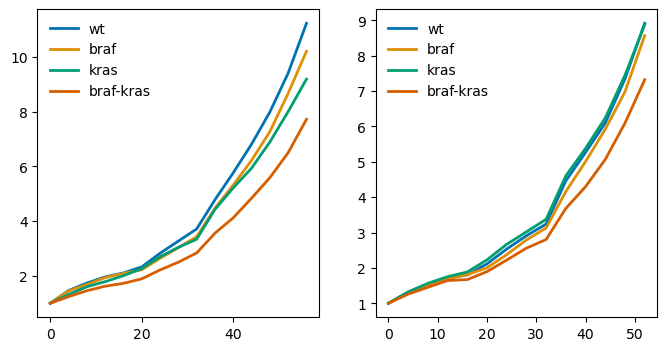

In [14]:
# plot all drug free conditions on one plot

fig,ax_list = plt.subplots(ncols=2,figsize=(8,4))

plate_indx = np.argwhere(np.array(data_file_names) == '1c_counts.csv')[0][0]

data = data_dict_list[plate_indx]

row_list = ['B','C','D']
ax = ax_list[0]
for col in range(2,6):
    ts_list = []
    for row in row_list:
        key = row+str(col)
        color = col_key_color[str(col)]
        ts = data[key][color]
        time = np.arange(len(ts))*4
        ts_list.append(ts)
    ts = np.nanmean(np.array(ts_list),axis=0)
    ts = ts/ts[0]
    ax.plot(time,ts,color=color_dict[col_key_genotype[str(col)]],linewidth=2,
            label=col_key_genotype[str(col)])
        # ax.plot(time,ts,color=color_dict[col_key_genotype[str(col)]],linewidth=2)

ax.legend(frameon=False)
# ax.set_yscale('log')

plate_indx = np.argwhere(np.array(data_file_names) == '3c_counts.csv')[0][0]

data = data_dict_list[plate_indx]

row_list = ['B','C','D']
ax = ax_list[1]
for col in range(2,6):
    ts_list = []
    for row in row_list:
        key = row+str(col)
        color = col_key_color[str(col)]
        ts = data[key][color]
        time = np.arange(len(ts))*4
        ts_list.append(ts)
    ts = np.nanmean(np.array(ts_list),axis=0)
    ts = ts/ts[0]
    ax.plot(time,ts,color=color_dict[col_key_genotype[str(col)]],linewidth=2,
            label=col_key_genotype[str(col)])
        # ax.plot(time,ts,color=color_dict[col_key_genotype[str(col)]],linewidth=2)

ax.legend(frameon=False)

# ax.set_yscale('log')